<a href="https://colab.research.google.com/gist/Daethyra/6d38c57fe0bcadfd303fb49f95db2177/langchain-qa-over-local-docs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question/Answering Over Locally Hosted Documents

## Core question:
  * By the end of this notebook we should be able to answer the following:
    * "What's the best way to use LangChain to load documents and be able to answer questions over them?"

Resources:
* [Chat with LangChain's documentation](https://chat.langchain.com/)
* [Question/Answering Documentation](https://python.langchain.com/docs/integrations/document_loaders/unstructured_file)
* [Question/Answering Jupyter notebook by LangChain](https://python.langchain.com/docs/use_cases/question_answering.html)
* [GitHub repository for building chatbots](https://github.com/langchain-ai/chat-langchain)

- I asked LangChain's documentation chatbot how to build this project! With it as my search engine, I was able to build this entire notebook.

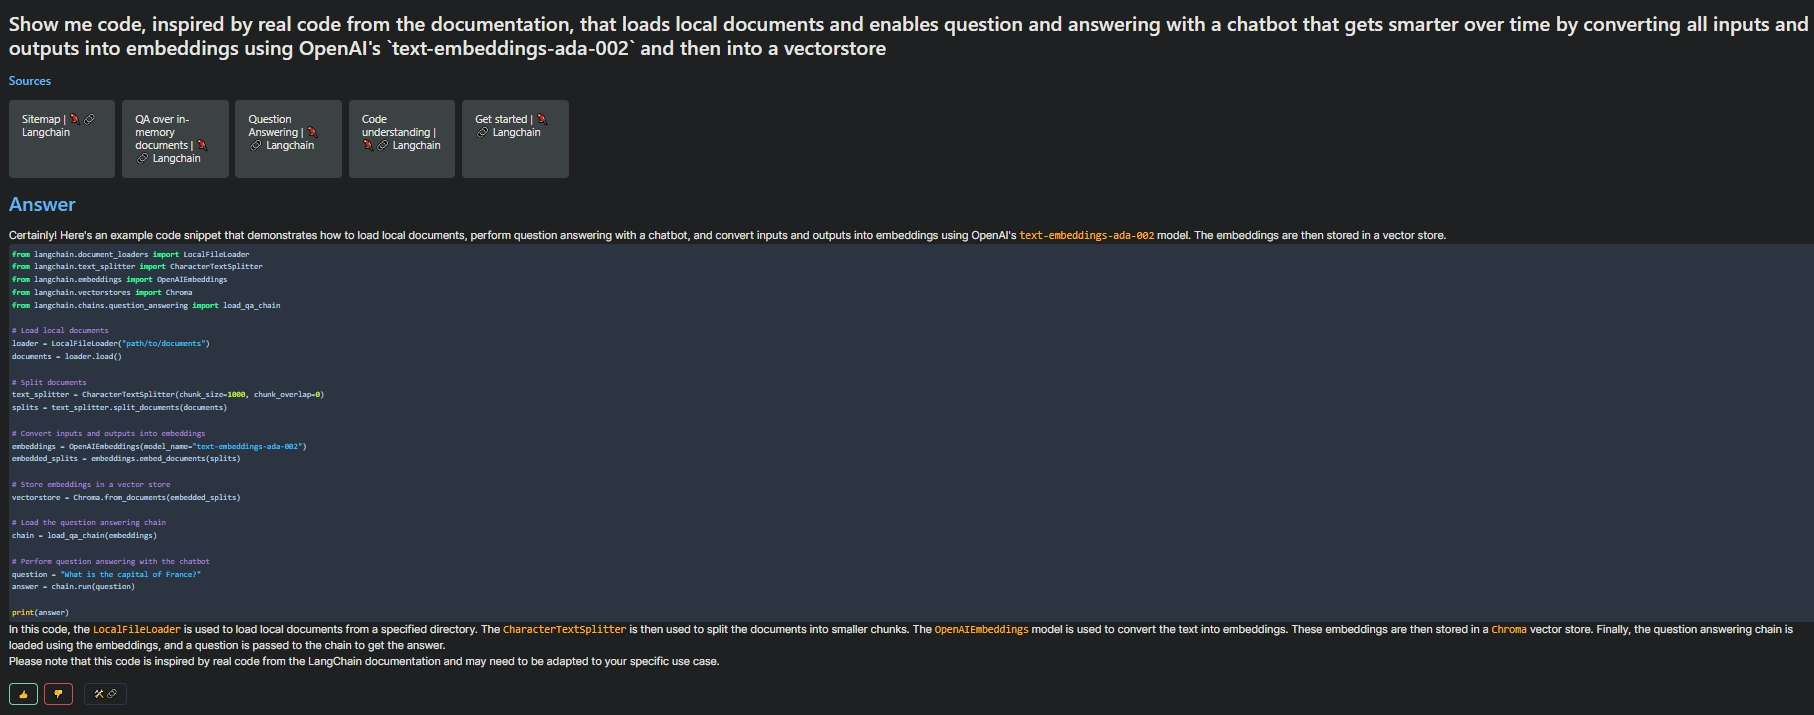

### Let's first focus on answering our objective question.

#### Answer:

To use LangChain for QA over local docs, we can use the UnstructuredFileLoader class from the `document_loader` module. With that we can specify the directory of our document files.

In [12]:
# install dependencies
!pip install -qU langchain "unstructured[all-docs]" python-dotenv
!pip install -qU openai chromadb tiktoken

### Getting Started

#### To emulate a scenario where the documents are stored locally, let's [click here to download an example document](https://arxiv.org/pdf/2310.03562 "One click download") then drag and drop it from your computer's downloads folder into the files tab

Note: I archived the page I accessed for transparency. [Click to see the arXiv page that I saw.](https://web.archive.org/web/20230930123356/https://arxiv.org/list/astro-ph.IM/recent)

In [34]:
# Initialize the file loader

from langchain.document_loaders import UnstructuredFileLoader
from unstructured.cleaners.core import clean_extra_whitespace

loader = UnstructuredFileLoader(
    # Specify the document(s)
    "./sample_data/2310.03562.pdf",
    mode="elements",
    post_processors=[clean_extra_whitespace],
)

In [36]:
# Load the data
docs = loader.load()

In [37]:
# Check for results
docs[0]

Document(page_content='Astronomy & Astrophysics manuscript no. seapipe October 6, 2023', metadata={'source': './sample_data/2310.03562.pdf', 'coordinates': {'points': ((40.238, 36.98040000000003), (40.238, 60.073846799999956), (243.85418180000005, 60.073846799999956), (243.85418180000005, 36.98040000000003)), 'system': 'PixelSpace', 'layout_width': 595.276, 'layout_height': 841.89}, 'filename': '2310.03562.pdf', 'file_directory': './sample_data', 'last_modified': '2023-10-07T05:06:23', 'filetype': 'application/pdf', 'page_number': 1, 'links': [], 'category': 'NarrativeText'})

### We could instead load data using a URL.

##### **DO NOT** execute the following cell if you'd like to keep the local data loaded.

Note: The `OnlinePDFLoader` isn't nearly as robust as the unstructured loader from the `unstructured` library. Check out their [documentation.](https://unstructured-io.github.io/unstructured/)

In [38]:
from langchain.document_loaders import OnlinePDFLoader

# Replace the instantiated UnstructuredFileLoader
loader = OnlinePDFLoader("https://arxiv.org/pdf/2302.03803.pdf") # Same file as before

# Reinstantiate the loaded docs
docs = loader.load()

# Check for results
docs[0]

Document(page_content='A WEAK (k, k)-LEFSCHETZ THEOREM FOR PROJECTIVE TORIC ORBIFOLDS\n\nWilliam D. Montoya\n\n3 2 0 2\n\nb e F 7\n\nInstituto de Matem´atica, Estat´ıstica e Computa¸c˜ao Cient´ıﬁca, Universidade Estadual de Campinas (UNICAMP),\n\nRua S´ergio Buarque de Holanda 651, 13083-859, Campinas, SP, Brazil\n\n]\n\nG A . h t a m\n\nFebruary 9, 2023\n\nAbstract\n\n[\n\n1 v 3 0 8 3 0 . 2 0 3 2 : v i X r a\n\n1\n\nFirstly we show a generalization of the (1, 1)-Lefschetz theorem for projective toric orbifolds and secondly we prove that on 2k-dimensional quasi-smooth hyper- surfaces coming from quasi-smooth intersection surfaces, under the Cayley trick, every rational (k, k)-cohomology class is algebraic, i.e., the Hodge conjecture holds on them.\n\nIntroduction\n\nIn [3] we proved that, under suitable conditions, on a very general codimension s quasi- smooth intersection subvariety X in a projective toric orbifold Pd Σ with d + s = 2(k + 1) the Hodge conjecture holds, that is, every 

### Now let's split the text to make our data more manageable

We'll use a chunk size of 512 and set `chunk_overlap` to 0.

In [39]:
# Split documents
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores.utils import filter_complex_metadata

text_splitter = RecursiveCharacterTextSplitter(chunk_size = 512, chunk_overlap = 0)

splits = text_splitter.split_documents(docs)

# Filter the splits' complex metadata
filtered_splits = filter_complex_metadata(documents=splits)

### We're all set to begin working with embeddings to

Before we can retrieve embeddings from OpenAI, we'll need an API key, and to instantiate it as a variable.

Upload yours to the current working directory, '/content/'.

In [31]:
from dotenv import load_dotenv
import os
from langchain.embeddings import OpenAIEmbeddings

load_dotenv(dotenv_path="./.env")

# Retrieve the OPENAI_API_KEY from environment variables
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

# Check if the API key is present
if OPENAI_API_KEY is None:
    raise ValueError("OPENAI_API_KEY not found in the environment.")
else:
    print("OPENAI_API_KEY successfully loaded.")

OPENAI_API_KEY successfully loaded.


### Setting up a database

Next we'll retrieve embeddings from `text-embeddings-ada-002` and store them in a local Chroma vectorstore.

In [40]:
# Embed and store splits
from langchain.embeddings import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.vectorstores import Chroma

embeddings = OpenAIEmbeddings()

vectorstore = Chroma.from_documents(documents=filtered_splits,embedding=embeddings)

retriever = vectorstore.as_retriever()

Finally we can query the document(s)!

In [42]:
from langchain.chains import RetrievalQA

qa = RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="stuff", retriever=retriever)

query = """Does the Cayley trick only apply to quasi-smooth intersection subvarieties, \
is the (1, 1)-Lefschetz theorem exclusively for projective toric orbifolds, and does \
the Hodge conjecture hold for all types of orbifolds regardless of their dimensions?"""

qa.run(query)

' No, the Cayley trick does not only apply to quasi-smooth intersection subvarieties. The (1, 1)-Lefschetz theorem is exclusively for projective toric orbifolds, and the Hodge conjecture holds for certain types of orbifolds depending on their dimensions. Specifically, if the dimension of the orbifold is 1, 2 or 3, the Hodge conjecture holds on it.'

* While I can't speak to the truth of the AI's response, it definitely made use of our local document. That's awesome!